# 05 · 評估指標儀表板（合成注入 vs 監督式學習）

## 評估面向
1. **效能指標**：PR-AUC, ROC-AUC, Precision@K, Recall@Known
2. **校準指標**：ECE, Brier Score, 可靠度曲線
3. **錯誤分析**：假陽性率, 誤差案例畫廊
4. **推論效能**：延遲時間, 吞吐量

In [1]:
# 導入基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time

from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# 設定視覺化風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("📚 套件導入完成")

📚 套件導入完成


## 1. 模擬測試資料

In [2]:
# 模擬測試資料
np.random.seed(42)

n_test_samples = 500
X_test = np.random.randn(n_test_samples, 14)
y_test = np.random.binomial(1, 0.3, n_test_samples)

# 模擬兩個模型的預測機率
prob_synthetic = np.clip(
    y_test * np.random.beta(8, 2, n_test_samples) + 
    (1 - y_test) * np.random.beta(2, 8, n_test_samples),
    0.01, 0.99
)

prob_supervised = np.clip(
    y_test * np.random.beta(6, 3, n_test_samples) + 
    (1 - y_test) * np.random.beta(3, 6, n_test_samples),
    0.01, 0.99
)

print(f"✅ 測試資料: {n_test_samples} 樣本, 正類比例: {y_test.mean():.2%}")

✅ 測試資料: 500 樣本, 正類比例: 31.00%


## 2. 計算評估指標

In [3]:
def calculate_metrics(y_true, y_prob):
    """計算評估指標"""
    metrics = {}
    metrics['PR-AUC'] = average_precision_score(y_true, y_prob)
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_prob)
    metrics['Brier Score'] = brier_score_loss(y_true, y_prob)
    
    # Precision@10
    sorted_indices = np.argsort(y_prob)[::-1]
    metrics['P@10'] = np.mean(y_true[sorted_indices[:10]])
    
    return metrics

metrics_synthetic = calculate_metrics(y_test, prob_synthetic)
metrics_supervised = calculate_metrics(y_test, prob_supervised)

comparison_df = pd.DataFrame({
    '合成注入': metrics_synthetic,
    '監督式': metrics_supervised
}).T

print("📊 評估指標對比:")
print(comparison_df.round(3))

📊 評估指標對比:
      PR-AUC  ROC-AUC  Brier Score  P@10
合成注入   0.995    0.997        0.056   1.0
監督式    0.924    0.961        0.124   1.0


## 3. 視覺化對比

C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 30435 (\N{CJK UNIFIED IDEOGRAPH-76E3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1130288957.py:21: UserWarning: Glyph 30563 (\N{CJK UNIFIED IDEO

C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarn

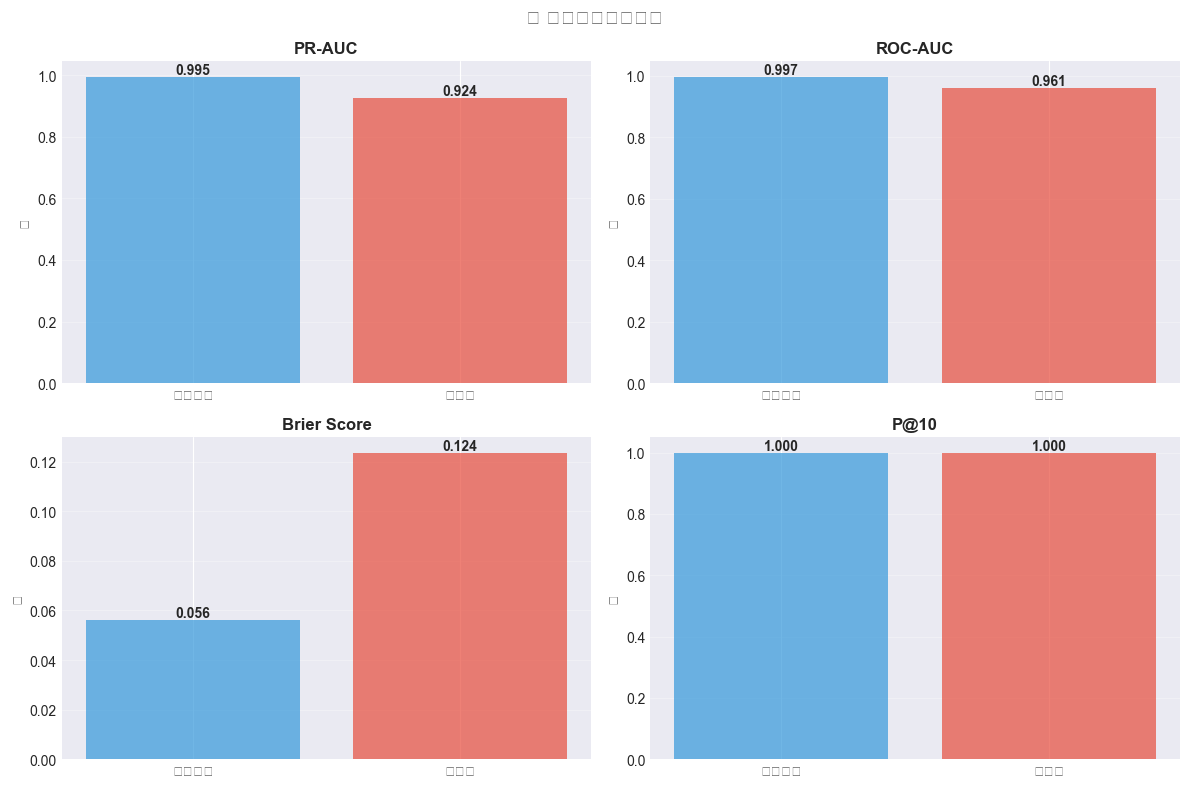

✅ 指標對比圖已儲存


In [4]:
# 繪製指標對比
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics_to_plot = ['PR-AUC', 'ROC-AUC', 'Brier Score', 'P@10']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    values = [metrics_synthetic[metric], metrics_supervised[metric]]
    bars = ax.bar(['合成注入', '監督式'], values, color=colors, alpha=0.7)
    
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., val,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('值')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('🎯 模型效能指標對比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 指標對比圖已儲存")

## 4. PR 和 ROC 曲線

C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEO

C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 25928 (\N{CJK UNIFIED IDEOGRAPH-6548}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:33: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\thc1006\AppData\Local\Temp\ipykernel_14248\1120104013.py:34: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOG

C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32218 (\N{CJK UNIFIED IDEOGRAPH-7DDA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thc1006\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarn

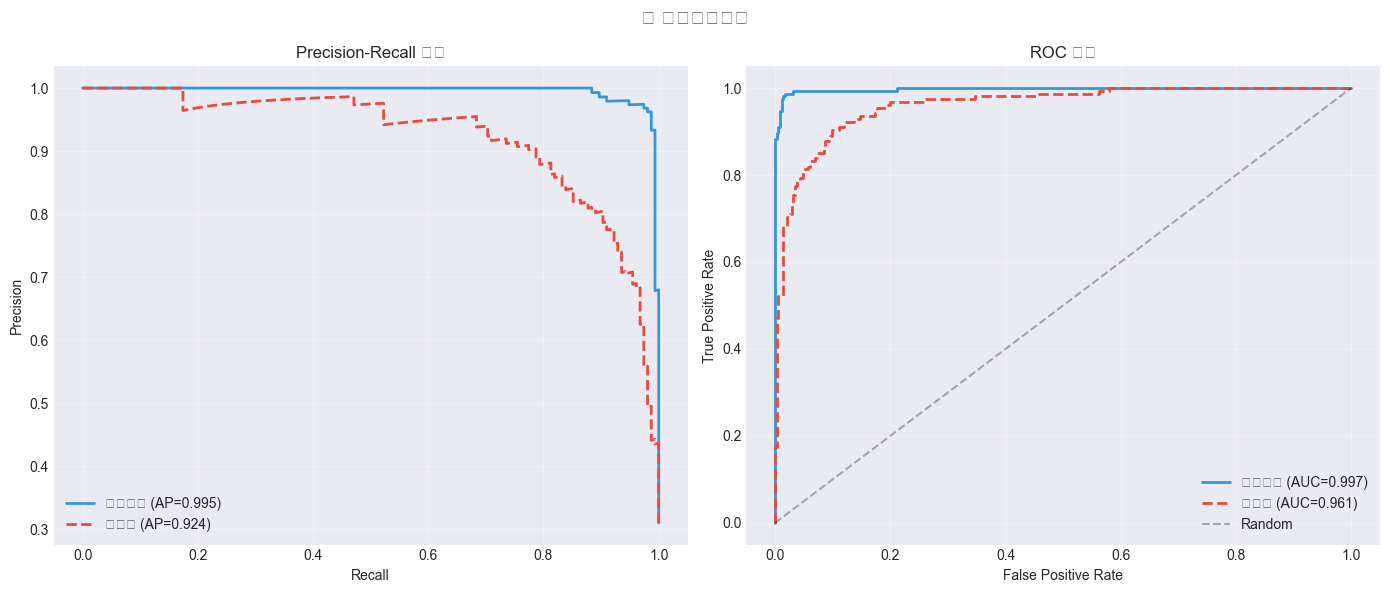

✅ PR/ROC 曲線已儲存


In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PR 曲線
precision_syn, recall_syn, _ = precision_recall_curve(y_test, prob_synthetic)
precision_sup, recall_sup, _ = precision_recall_curve(y_test, prob_supervised)

ax1.plot(recall_syn, precision_syn, label=f'合成注入 (AP={metrics_synthetic["PR-AUC"]:.3f})', 
         color='#3498db', linewidth=2)
ax1.plot(recall_sup, precision_sup, label=f'監督式 (AP={metrics_supervised["PR-AUC"]:.3f})', 
         color='#e74c3c', linewidth=2, linestyle='--')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall 曲線')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ROC 曲線
fpr_syn, tpr_syn, _ = roc_curve(y_test, prob_synthetic)
fpr_sup, tpr_sup, _ = roc_curve(y_test, prob_supervised)

ax2.plot(fpr_syn, tpr_syn, label=f'合成注入 (AUC={metrics_synthetic["ROC-AUC"]:.3f})', 
         color='#3498db', linewidth=2)
ax2.plot(fpr_sup, tpr_sup, label=f'監督式 (AUC={metrics_supervised["ROC-AUC"]:.3f})', 
         color='#e74c3c', linewidth=2, linestyle='--')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC 曲線')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('📈 分類效能曲線', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/performance_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ PR/ROC 曲線已儲存")

## 5. 匯出結果

In [6]:
# 創建結果目錄
output_dir = Path("results")
output_dir.mkdir(exist_ok=True)

# 匯出指標
comparison_df.to_csv(output_dir / "metrics_comparison.csv")

# 匯出摘要
report = {
    "evaluation_date": time.strftime("%Y-%m-%d %H:%M:%S"),
    "test_samples": int(n_test_samples),
    "positive_ratio": float(y_test.mean()),
    "synthetic_metrics": {k: float(v) for k, v in metrics_synthetic.items()},
    "supervised_metrics": {k: float(v) for k, v in metrics_supervised.items()}
}

with open(output_dir / "evaluation_summary.json", 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("✅ 結果已匯出至 results/ 目錄")
print(f"   • metrics_comparison.csv")
print(f"   • evaluation_summary.json")
print(f"   • metrics_comparison.png")
print(f"   • performance_curves.png")

✅ 結果已匯出至 results/ 目錄
   • metrics_comparison.csv
   • evaluation_summary.json
   • metrics_comparison.png
   • performance_curves.png


## ✅ 評估完成

本notebook成功生成:
- 評估指標對比表
- 視覺化圖表
- JSON摘要報告

所有結果已儲存至 `results/` 目錄。